In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import PlaceCellAnalysis as pc
import pickle

os.sys.path.append('../')
import utilities as u
import preprocessing as pp
import behavior as b
import logistic_regression as lr
import matplotlib.gridspec as gridspec

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()
df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]


G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [317]:
mouse = '4139265.3'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1403,4139265.3,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...
1405,4139265.3,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...
1433,4139265.3,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.3\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...
1455,4139265.3,15_02_2019,4,TwoTower_foraging,72,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.3\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...
1475,4139265.3,17_02_2019,2,TwoTower_foraging,81,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.3\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...
1495,4139265.3,19_02_2019,2,TwoTower_foraging,92,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.3\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...
1513,4139265.3,21_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.3\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...
1522,4139265.3,22_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-22,G:\My Drive\VR_Data\TwoTower\4139265.3\22_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...
1531,4139265.3,23_02_2019,2,TwoTower_foraging,93,1,CA1,2019-02-23,G:\My Drive\VR_Data\TwoTower\4139265.3\23_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...
1537,4139265.3,24_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-24,G:\My Drive\VR_Data\TwoTower\4139265.3\24_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...


In [328]:
sess = df_mouse.iloc[-1]
fname = os.path.join("G:\\My Drive\\Figures\\TwoTower\\LogReg",mouse,"%s_%d_Xhat.pkl" % (sess['DateFolder'],sess['SessionNumber']))


In [329]:
VRDat,C, S, A = pp.load_scan_sess(sess)


num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
frame diff 0


In [330]:
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values)
effMorph = trial_info['morphs']+trial_info['bckgndJitter']+trial_info['towerJitter']
effMorph = (effMorph+.2)/1.4

In [331]:
with open(fname,"rb") as f:
    d = pickle.load(f)
    Xhat = d['Xhat']

In [332]:
print(Xhat.shape)

(32038, 44)


In [333]:

num,den = Xhat[:,:22].sum(axis=1),Xhat[:,22:].sum(axis=1)
rat = np.log(num)-np.log(den)


C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


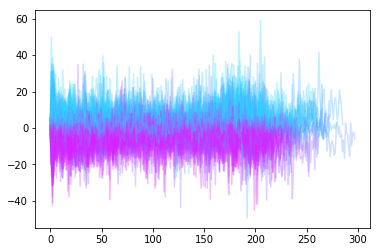

In [334]:
f,ax = plt.subplots()
for ind,(tstart,tstop) in enumerate(zip(tstart_inds.to_list(),teleport_inds.tolist())):
    ax.plot(rat[tstart:tstop],color=plt.cm.cool(effMorph[ind]),alpha=.3)
    

In [335]:
rat_trial_mat = u.make_pos_bin_trial_matrices(rat,VRDat.pos._values,VRDat['tstart']._values,VRDat['teleport']._values,mat_only=True,bin_size=10)

((<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1c892d08a20>),
 (<Figure size 1440x360 with 5 Axes>,
  array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C892CF1898>,
        dtype=object)),
 (<Figure size 720x720 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1c892f415f8>),
 (<Figure size 432x288 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1c892f750f0>))

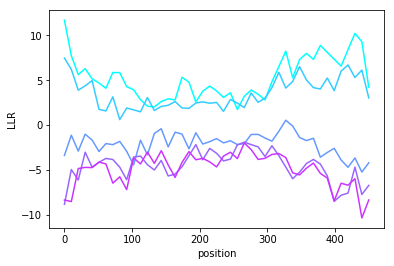

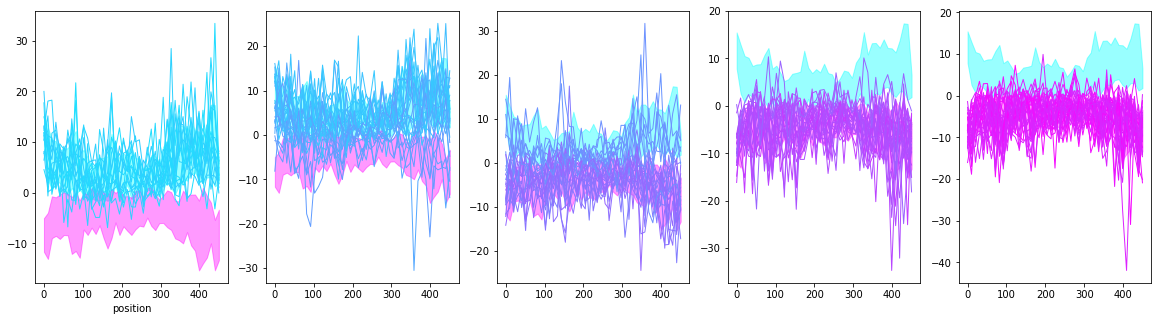

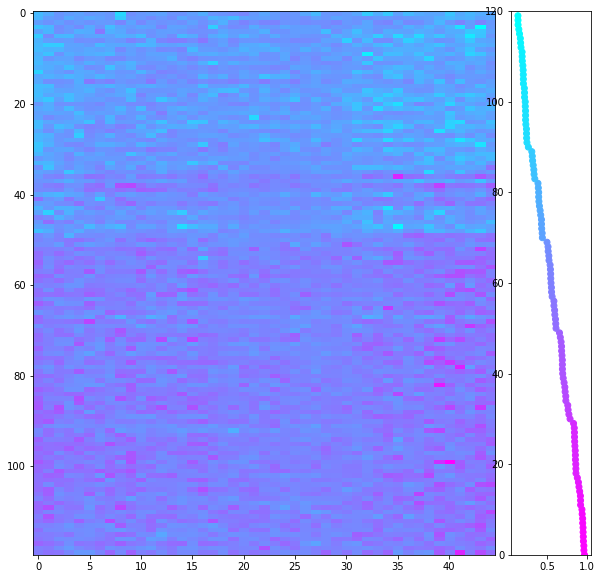

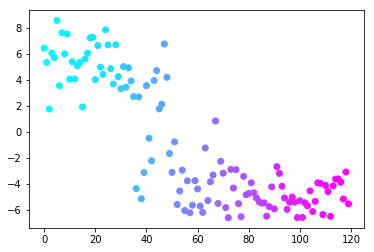

In [336]:
lr.plot_llr(rat_trial_mat[:,:],effMorph)

(120, 45)


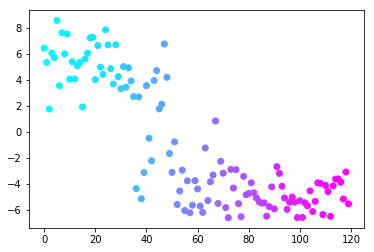

In [337]:
f,ax = plt.subplots()
print(rat_trial_mat.shape)
ax.scatter(np.arange(effMorph.shape[0]),rat_trial_mat.mean(axis=-1)[np.argsort(effMorph)],c=effMorph[np.argsort(effMorph)],cmap='cool')

(array([0.02630471, 0.13809972, 0.17098061, 0.11179501, 0.05918559,
        0.03945706, 0.05918559, 0.09864266, 0.07233795, 0.01315235]),
 array([-6.36524691, -5.09804665, -3.8308464 , -2.56364614, -1.29644589,
        -0.02924563,  1.23795462,  2.50515488,  3.77235513,  5.03955539,
         6.30675564]),
 <a list of 10 Patch objects>)

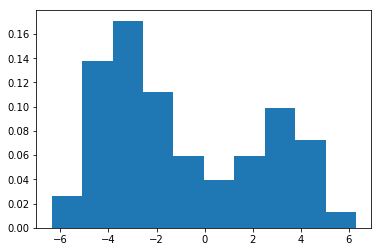

In [316]:
f,ax = plt.subplots()
ax.hist(rat_trial_mat.mean(axis=-1),bins=10,density=True)